In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'USD'
share_name = 'BTO.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2013-12-31,138,-102,36,26,253,26,76,375,202,...,2310,0,0,13,99,283,646,38,-77,663.8
1,2014-03-31,129,-92,37,-24,184,18,82,314,202,...,2312,0,0,23,76,322,664,18,-95,741.1
2,2014-06-30,120,-98,22,-12,135,18,80,266,202,...,2334,0,0,11,70,373,690,24,-88,741.1
3,2014-09-30,115,-99,16,-274,179,15,83,298,0,...,2599,0,0,8,82,390,762,34,-63,741.1
4,2014-12-31,122,-104,19,-357,133,14,96,260,0,...,2119,0,0,11,85,369,649,41,-66,741.1


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2022-12-31,2023-02-11,1071.0,592,-332,261,176,652,0,332,...,0,3681,0,0,16,234,13,673,270,-113
37,2023-03-31,2023-04-21,1237.4,474,-260,214,102,674,0,350,...,0,3768,0,0,15,268,11,721,204,-111
38,2023-06-30,2023-07-21,1237.4,471,-281,190,92,506,0,339,...,0,4931,0,0,17,319,15,909,195,-205
39,2023-09-30,2023-10-21,1237.4,478,-307,171,-35,310,0,344,...,0,4852,0,0,15,325,12,895,110,-226
40,2023-12-31,2024-02-11,1237.4,512,-306,206,-117,307,0,346,...,0,4875,0,0,16,313,152,1064,205,-269


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,1071.0,592,-332,261,176,652,0,332,...,3681,0,0,16,234,13,673,270,-113,1.357405
37,2023-03-31,2023-04-21,1237.4,474,-260,214,102,674,0,350,...,3768,0,0,15,268,11,721,204,-111,1.352063
38,2023-06-30,2023-07-21,1237.4,471,-281,190,92,506,0,339,...,4931,0,0,17,319,15,909,195,-205,1.343352
39,2023-09-30,2023-10-21,1237.4,478,-307,171,-35,310,0,344,...,4852,0,0,15,325,12,895,110,-226,1.341033
40,2023-12-31,2024-02-11,1237.4,512,-306,206,-117,307,0,346,...,4875,0,0,16,313,152,1064,205,-269,1.361617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,1071.0,803.583810,-450.658488,354.282727,238.903295,885.028115,0.0,450.658488,...,4996.608117,0.0,0.0,21.718481,317.632790,17.646266,913.533622,366.499373,-153.386775,1.357405
37,2023-03-31,2023-04-21,1237.4,640.877699,-351.536290,289.341408,137.910391,911.290230,0.0,473.221929,...,5094.572086,0.0,0.0,20.280940,362.352792,14.872689,974.837175,275.820782,-150.078955,1.352063
38,2023-06-30,2023-07-21,1237.4,632.718662,-377.481834,255.236827,123.588359,679.735972,0.0,455.396234,...,6624.067349,0.0,0.0,22.836979,428.529200,20.150276,1221.106717,261.953586,-275.387103,1.343352
39,2023-09-30,2023-10-21,1237.4,641.013737,-411.697107,229.316630,-46.936152,415.720206,0.0,461.315326,...,6506.691743,0.0,0.0,20.115494,435.835700,16.092395,1200.224466,147.513622,-303.073441,1.341033
40,2023-12-31,2024-02-11,1237.4,697.148103,-416.654921,280.493182,-159.309235,418.016538,0.0,471.119617,...,6637.884772,0.0,0.0,21.785878,426.186243,206.965843,1448.760902,279.131565,-366.275078,1.361617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-02-17,2.690844,2013-12-31,144.815842,0.164412,2.630589,663.8,482.719475,0.727206,265.495711,...,0.720346,0.279654,21.230769,inf,2.181818,5.368421,0.26087,0.188406,0.045022,0.0625
1,2014-02-24,2.707767,2013-12-31,144.815842,0.164412,2.630589,663.8,482.719475,0.727206,265.495711,...,0.720346,0.279654,21.230769,inf,2.181818,5.368421,0.26087,0.188406,0.045022,0.0625
2,2014-03-03,2.826232,2013-12-31,144.815842,0.164412,2.630589,663.8,482.719475,0.727206,265.495711,...,0.720346,0.279654,21.230769,inf,2.181818,5.368421,0.26087,0.188406,0.045022,0.0625
3,2014-03-10,2.902388,2013-12-31,144.815842,0.164412,2.630589,663.8,482.719475,0.727206,265.495711,...,0.720346,0.279654,21.230769,inf,2.181818,5.368421,0.26087,0.188406,0.045022,0.0625
4,2014-03-17,2.631611,2013-12-31,144.815842,0.164412,2.630589,663.8,482.719475,0.727206,265.495711,...,0.720346,0.279654,21.230769,inf,2.181818,5.368421,0.26087,0.188406,0.045022,0.0625


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-02-17,2.690844,2013-12-31,144.815842,0.164412,2.630589,663.8,482.719475,0.727206,265.495711,...,5.368421,0.26087,0.188406,0.045022,0.0625,16.366483,1.022905,3.083540,3.795497,3.700248
1,2014-02-24,2.707767,2013-12-31,144.815842,0.164412,2.630589,663.8,482.719475,0.727206,265.495711,...,5.368421,0.26087,0.188406,0.045022,0.0625,16.469415,1.029338,3.102933,3.814890,3.723520
2,2014-03-03,2.826232,2013-12-31,144.815842,0.164412,2.630589,663.8,482.719475,0.727206,265.495711,...,5.368421,0.26087,0.188406,0.045022,0.0625,17.189953,1.074372,3.238687,3.950643,3.886424
3,2014-03-10,2.902388,2013-12-31,144.815842,0.164412,2.630589,663.8,482.719475,0.727206,265.495711,...,5.368421,0.26087,0.188406,0.045022,0.0625,17.653156,1.103322,3.325957,4.037914,3.991148
4,2014-03-17,2.631611,2013-12-31,144.815842,0.164412,2.630589,663.8,482.719475,0.727206,265.495711,...,5.368421,0.26087,0.188406,0.045022,0.0625,16.006214,1.000388,3.015664,3.727620,3.618796


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

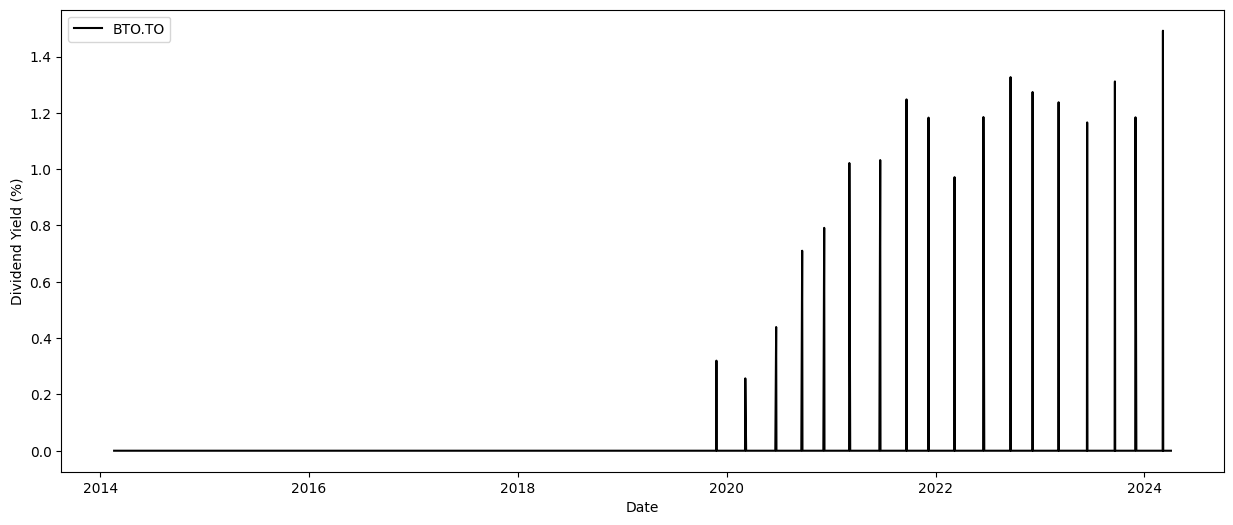

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.257268
share_price      1.000000
Name: share_price, dtype: float64


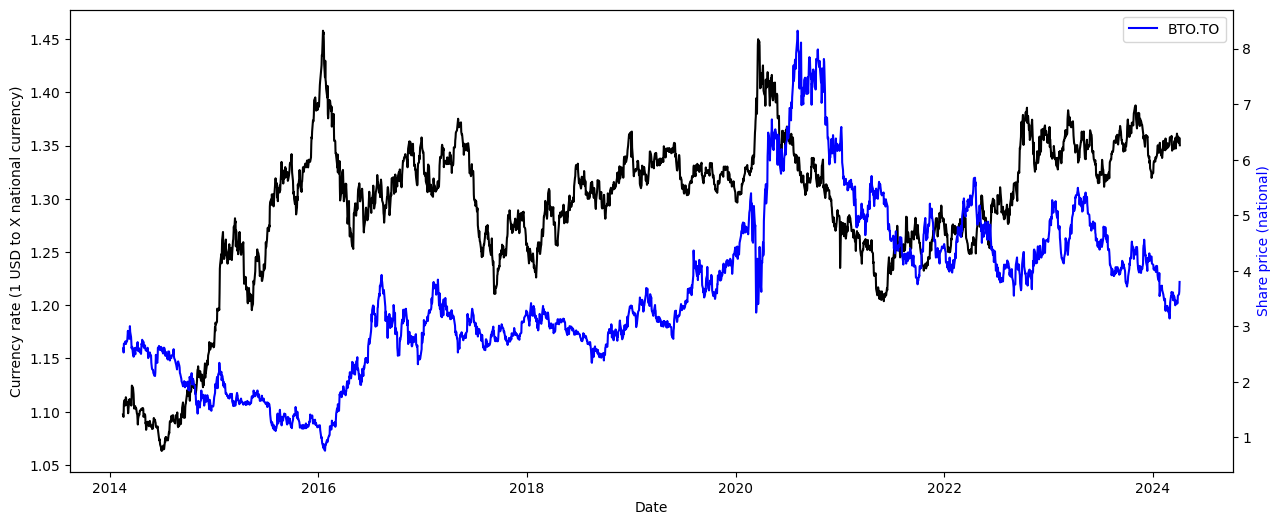

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

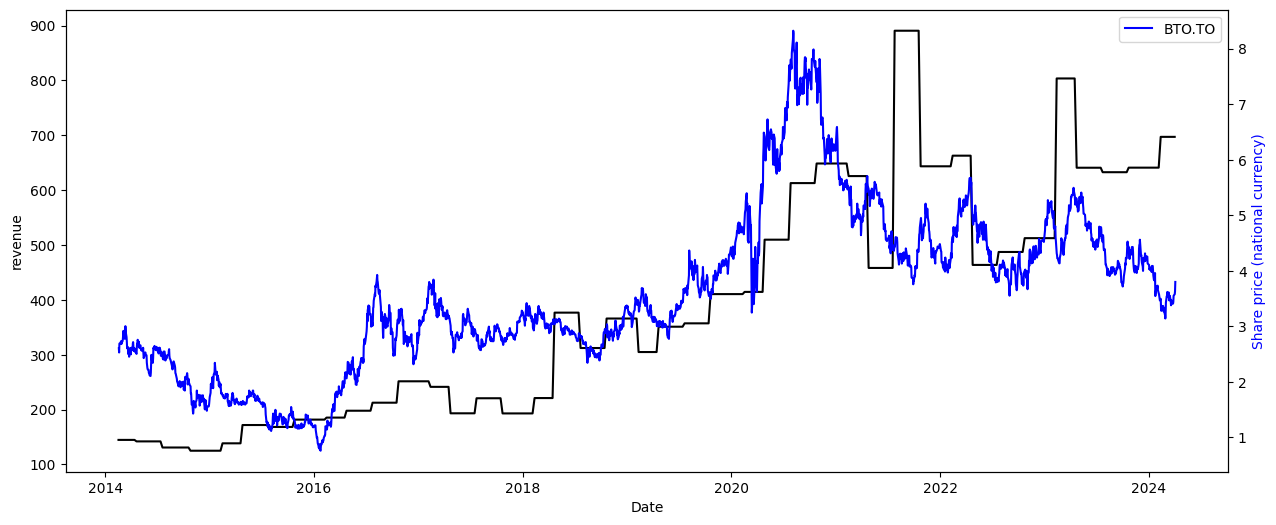

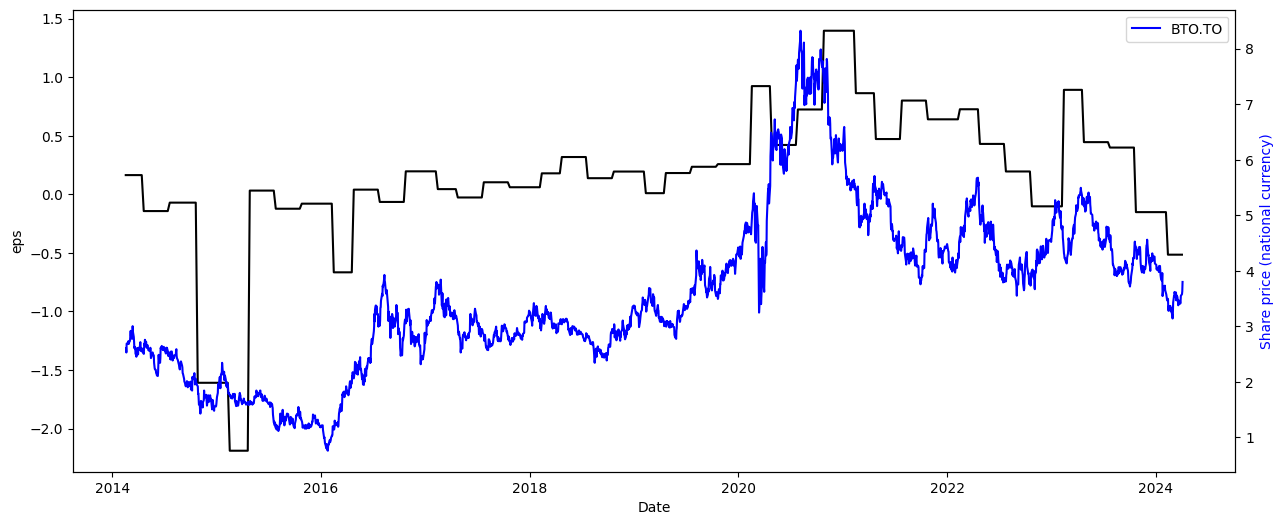

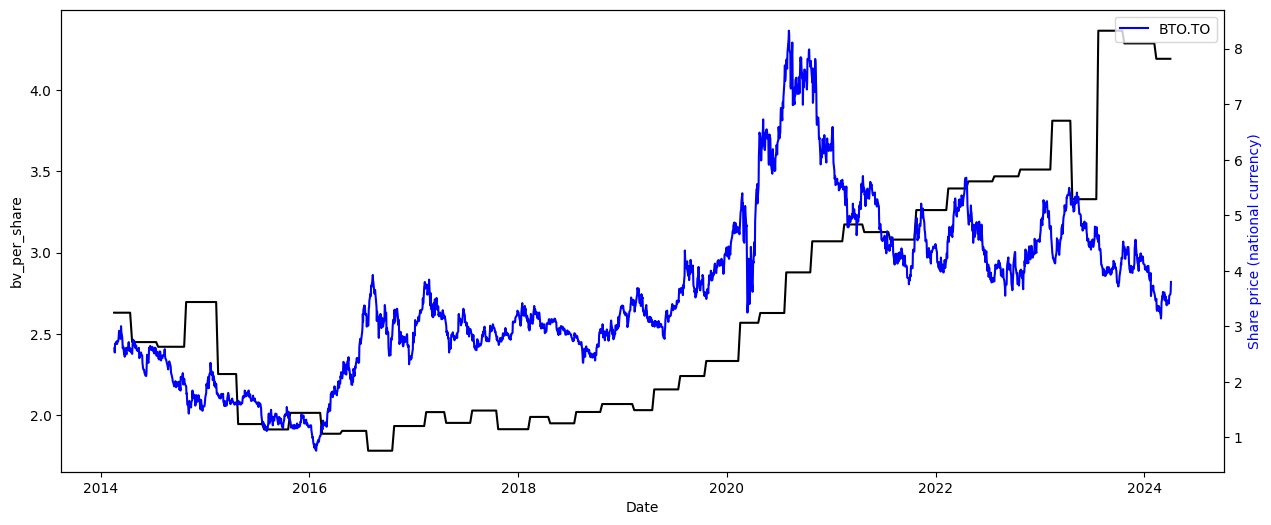

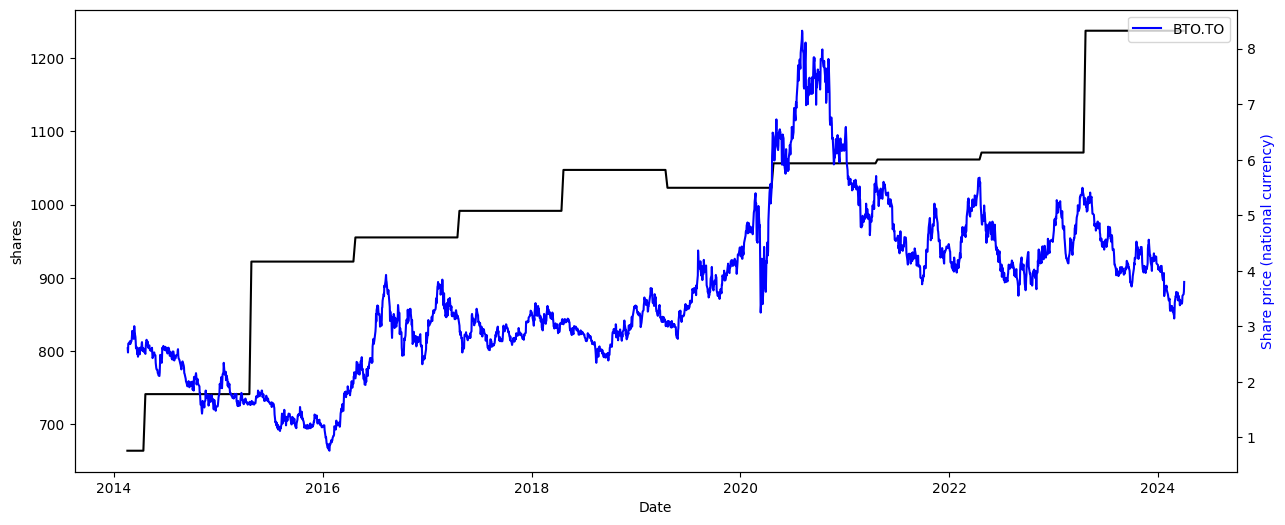

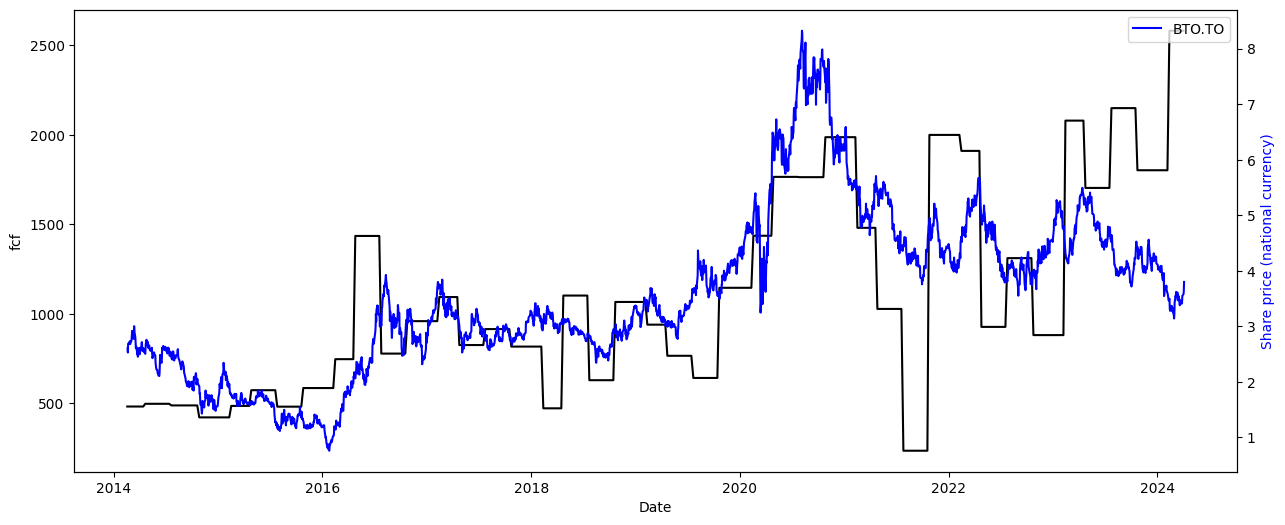

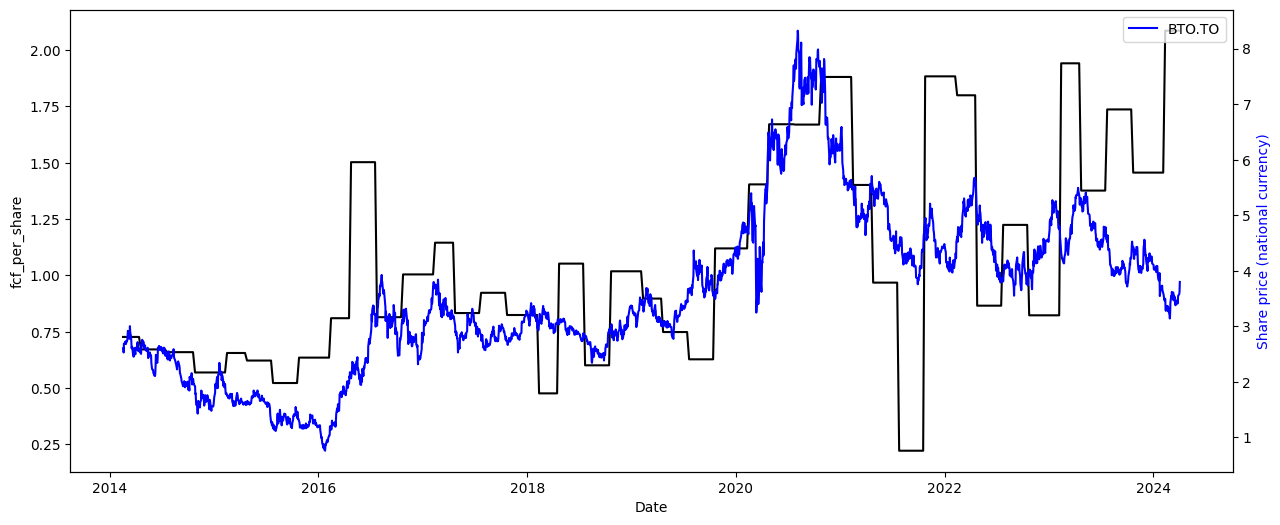

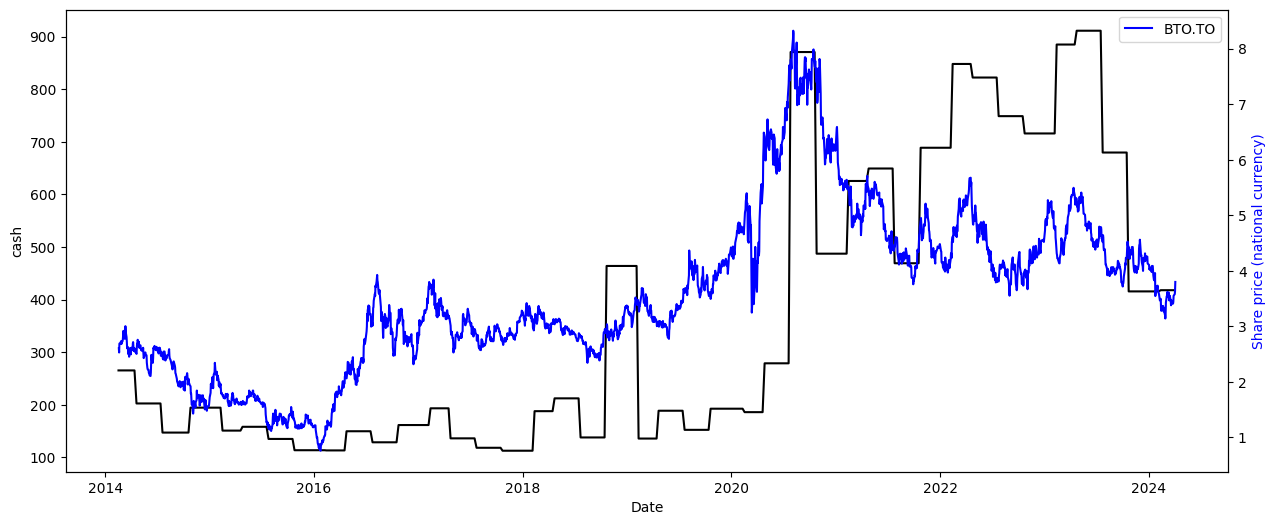

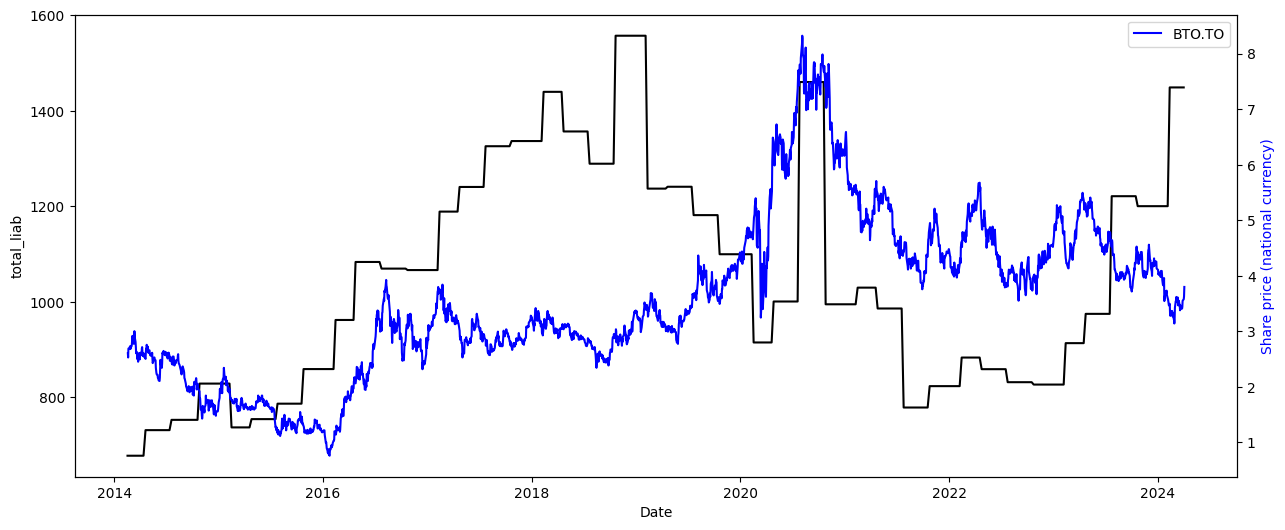

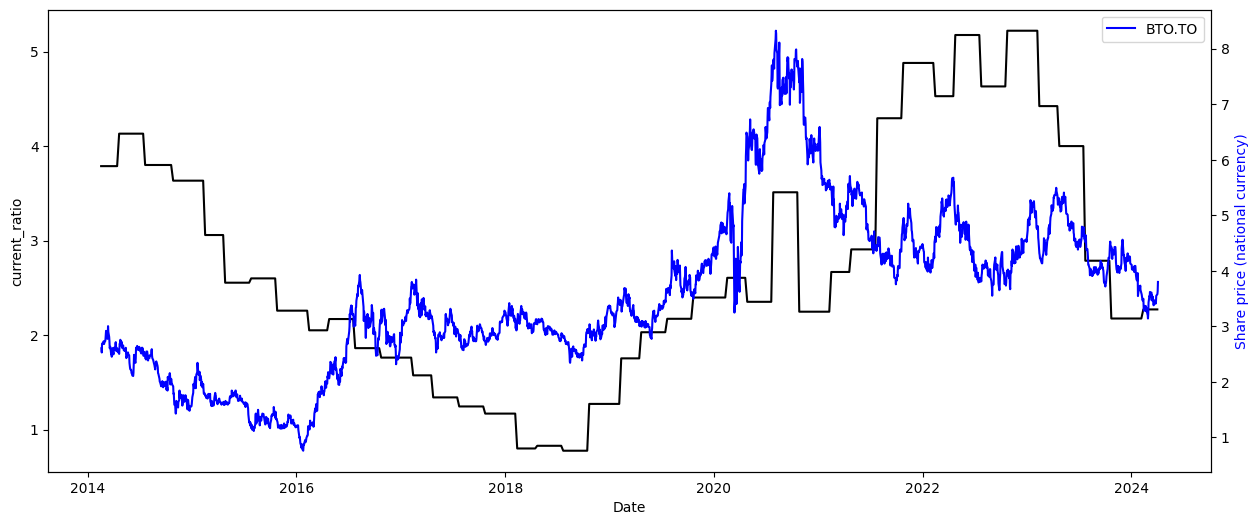

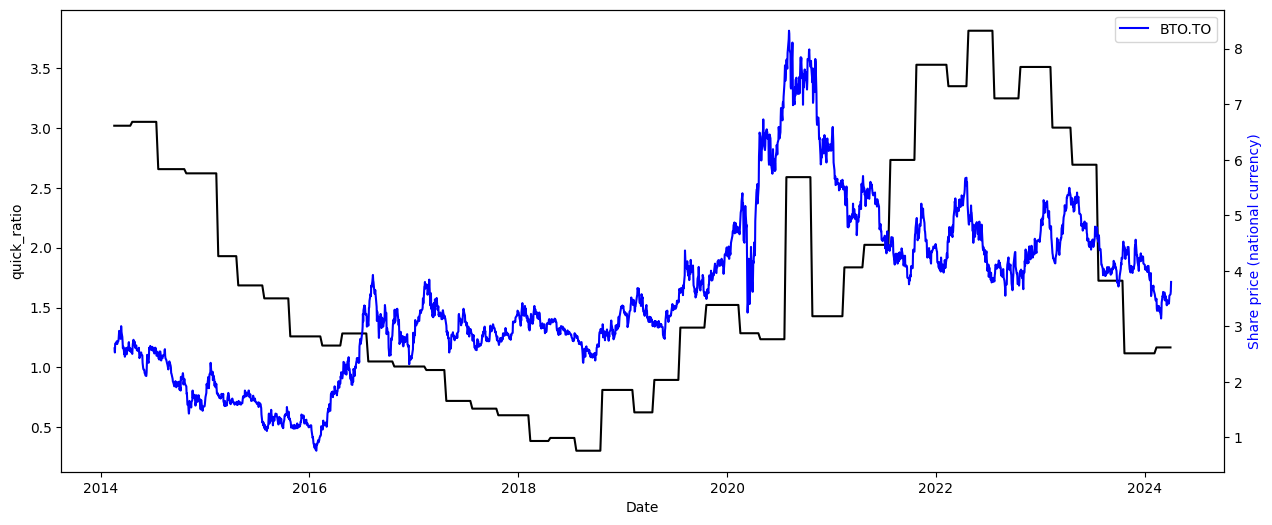

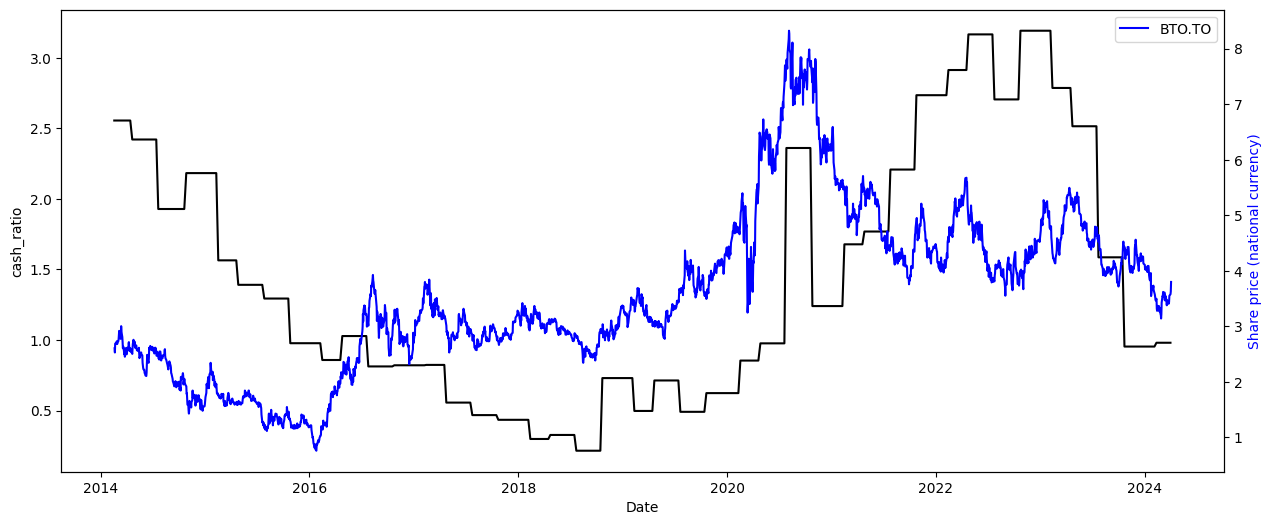

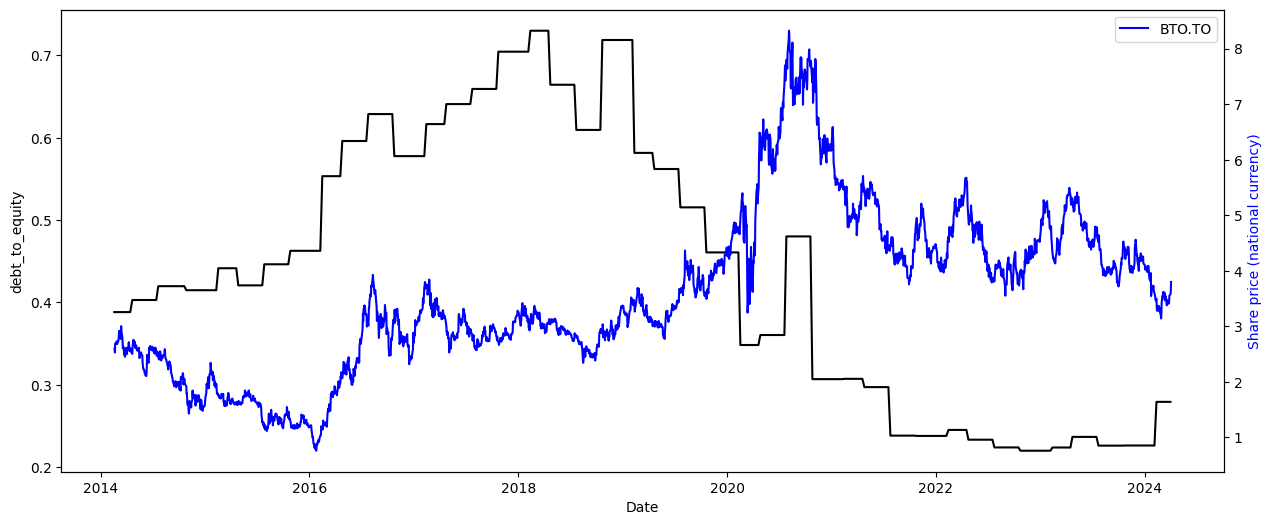

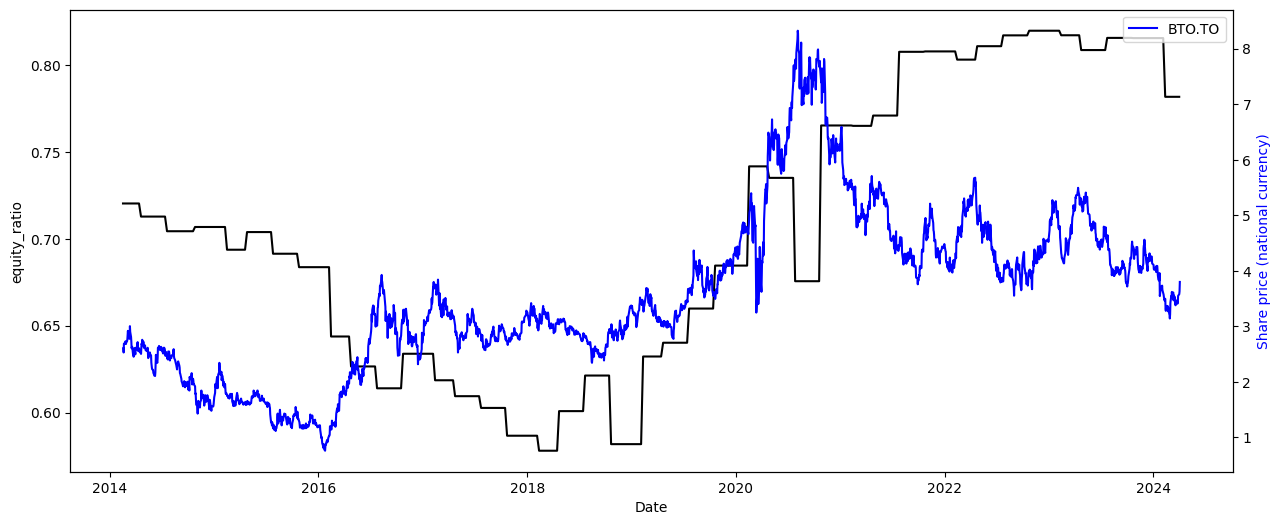

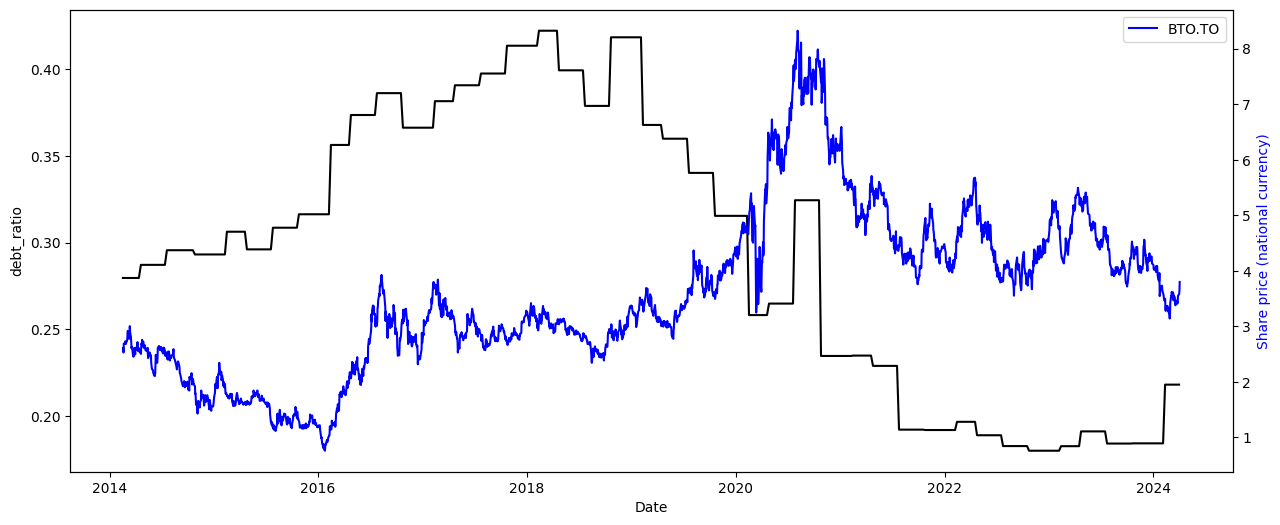

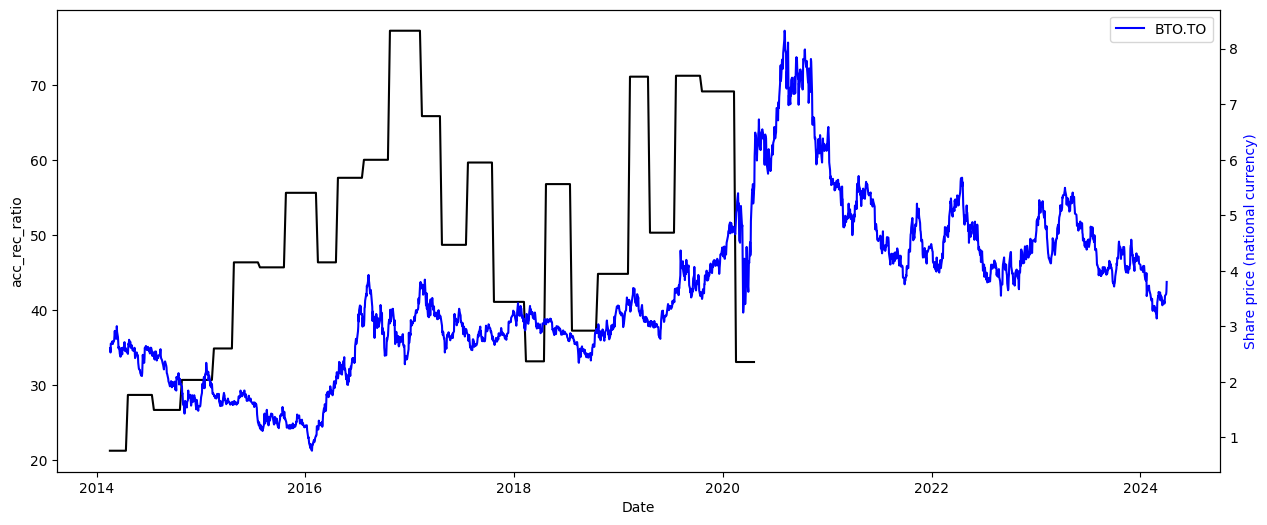

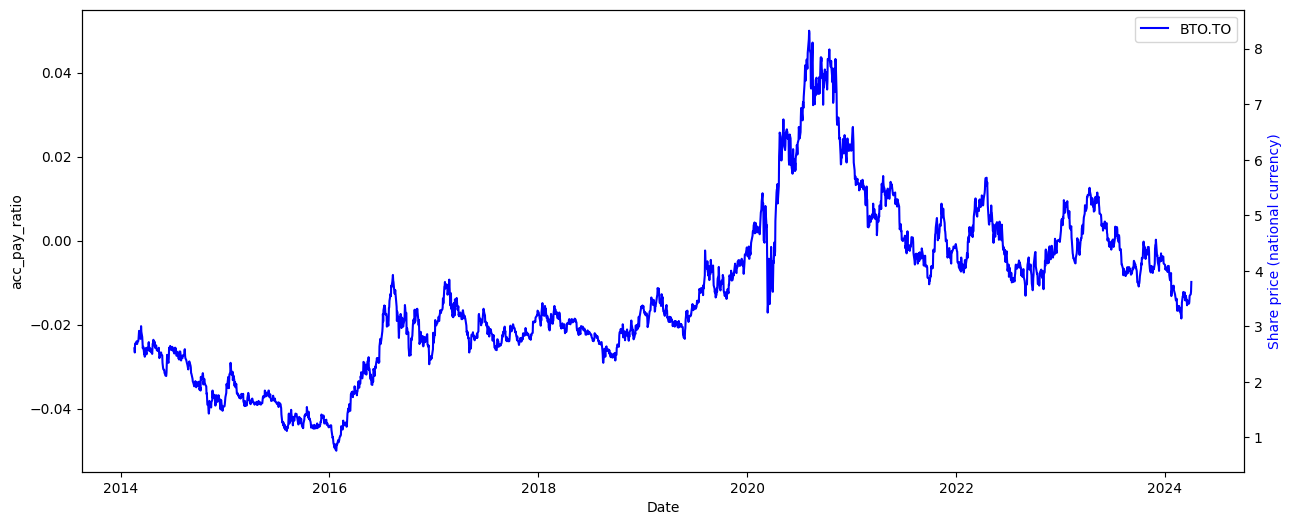

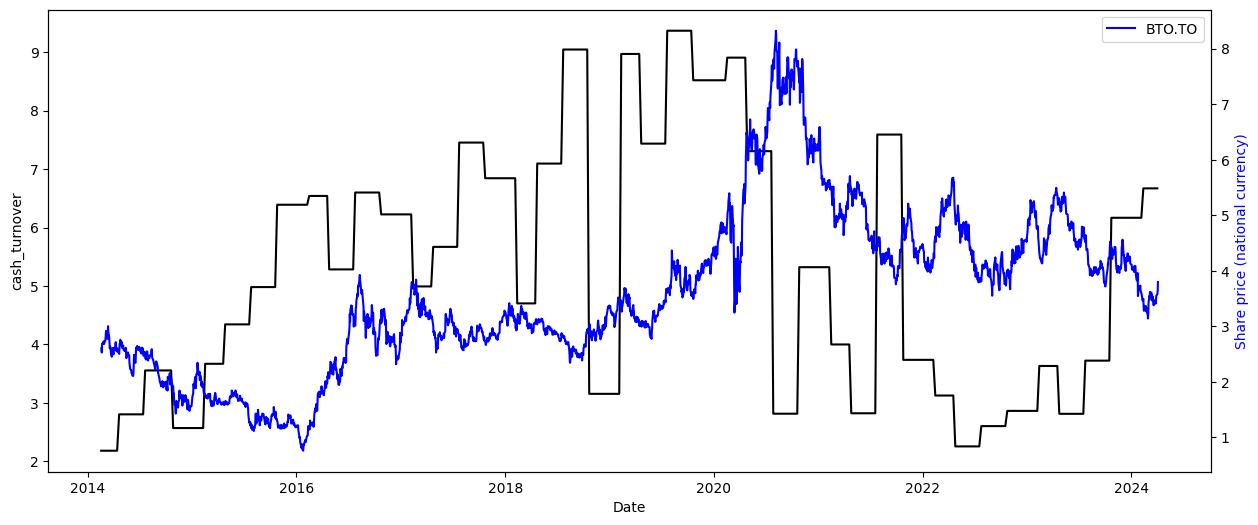

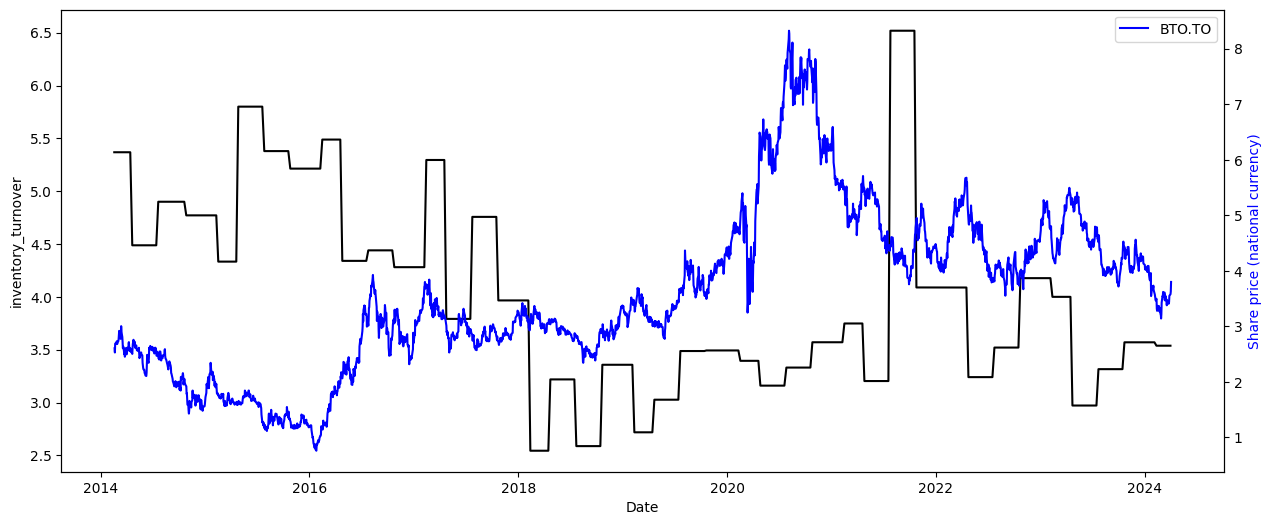

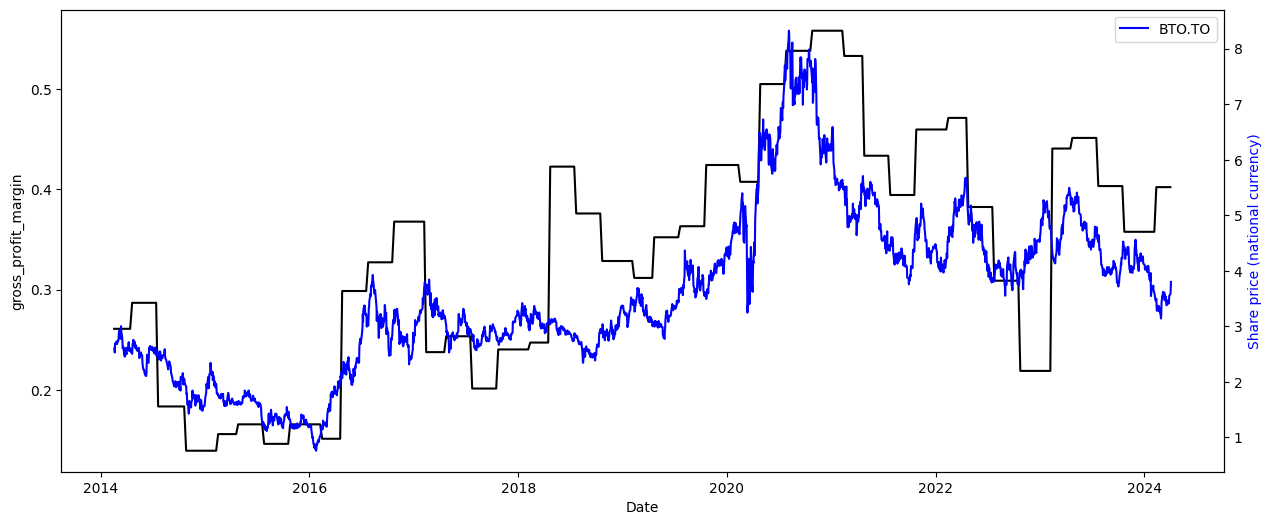

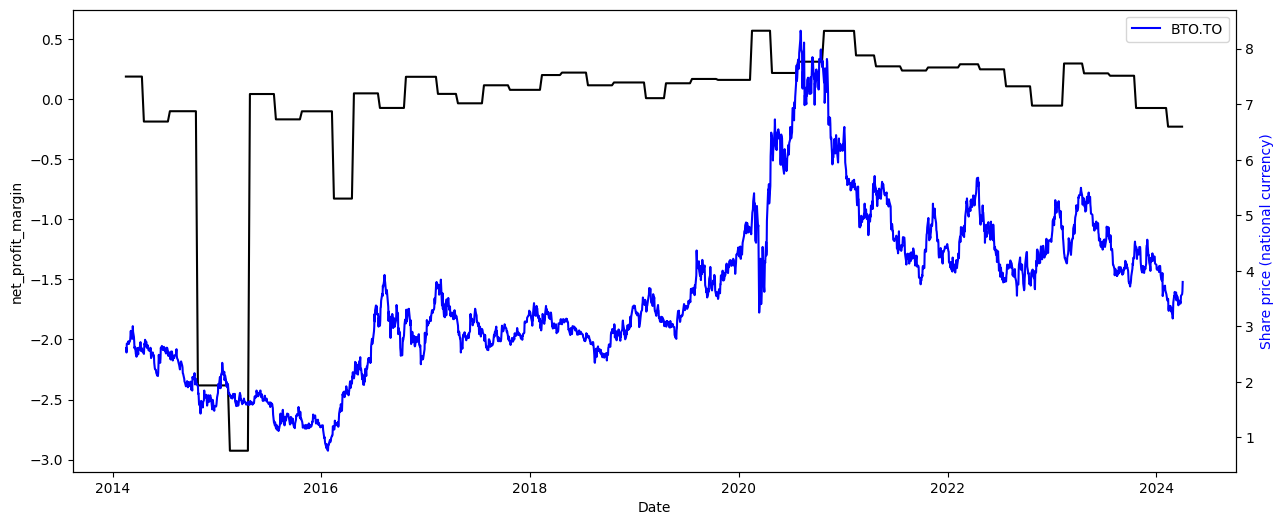

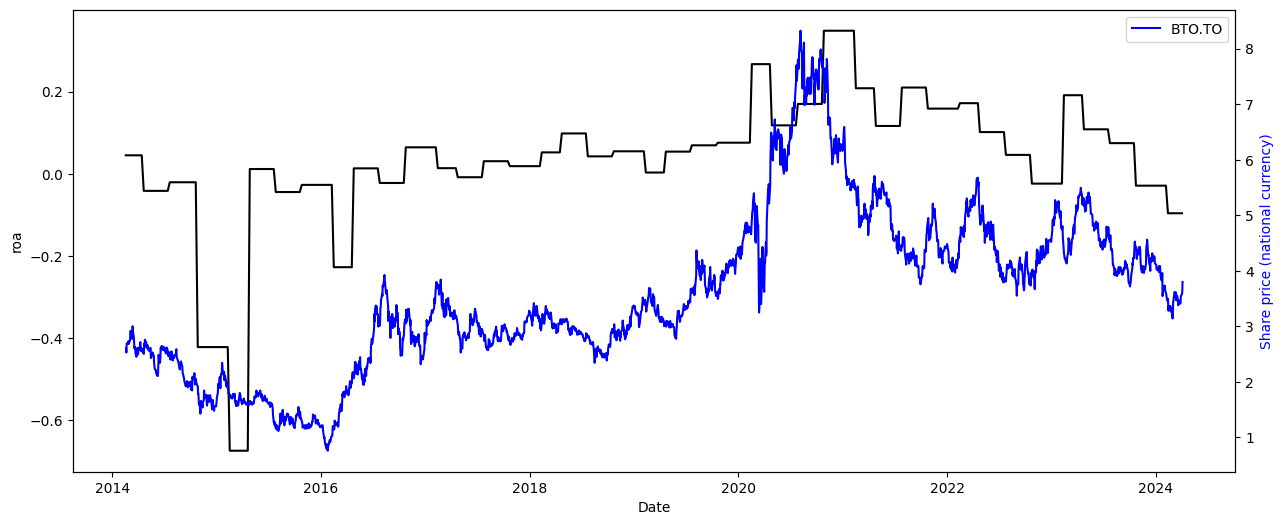

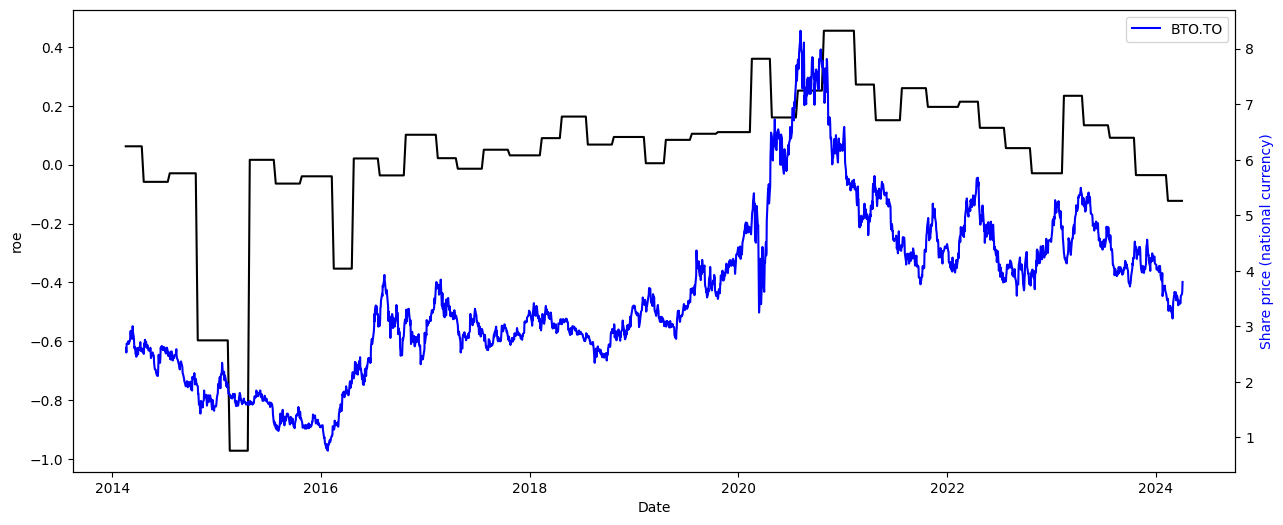

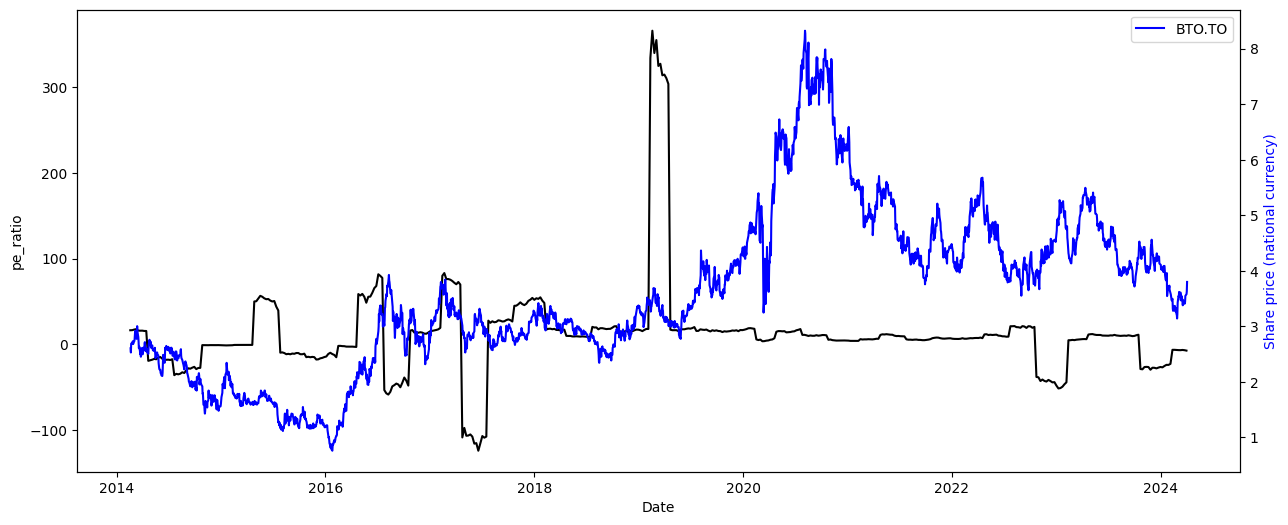

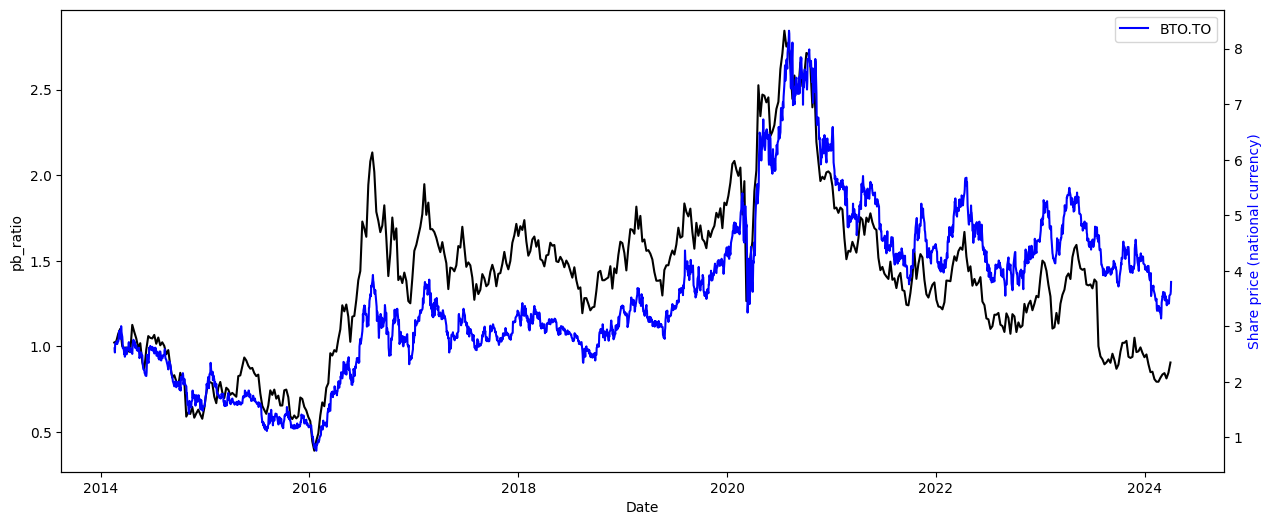

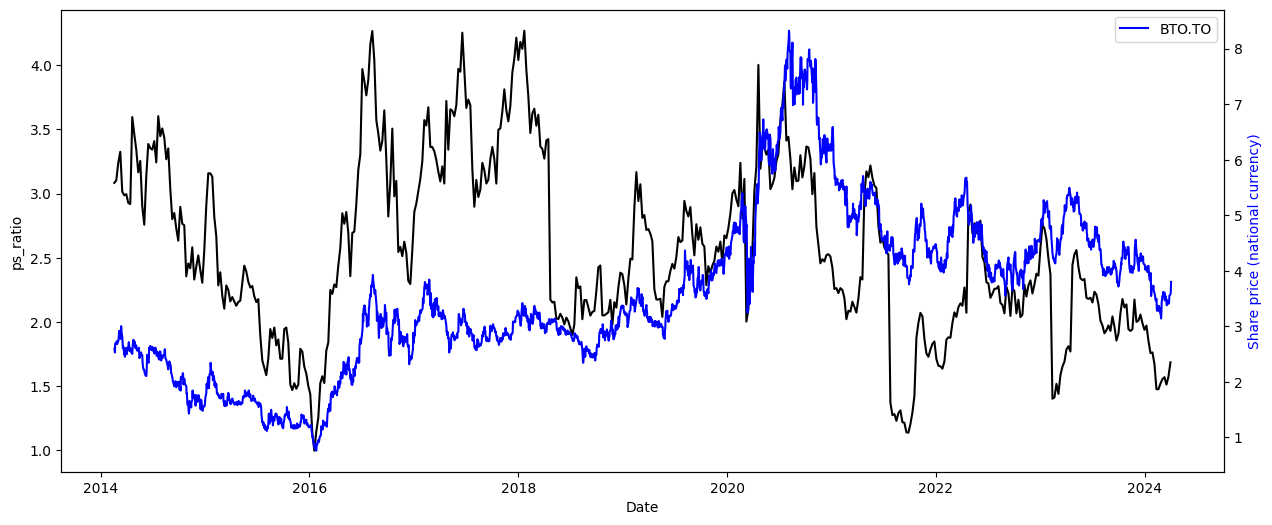

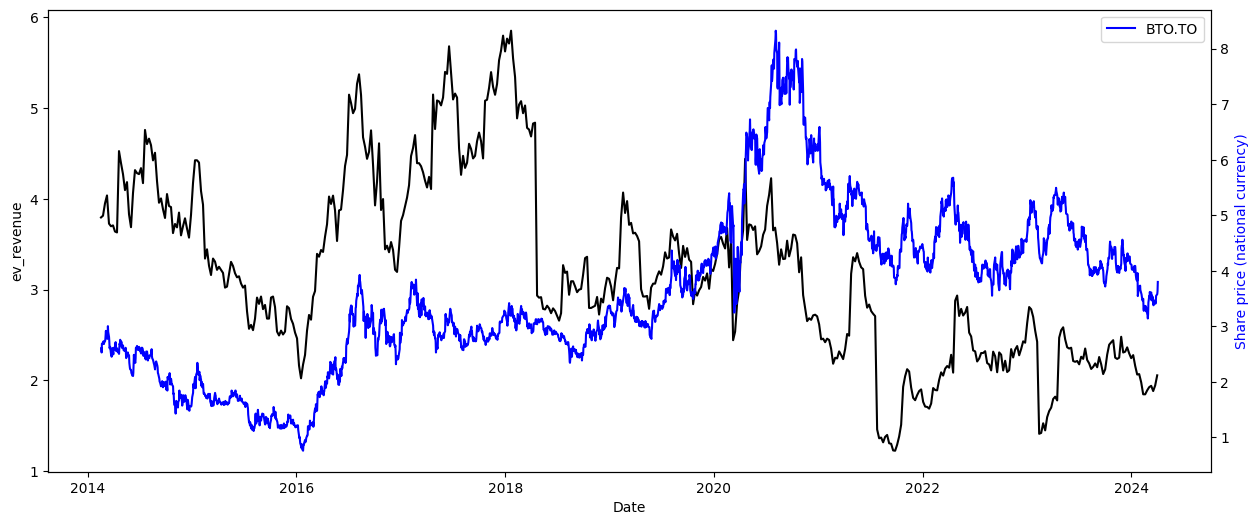

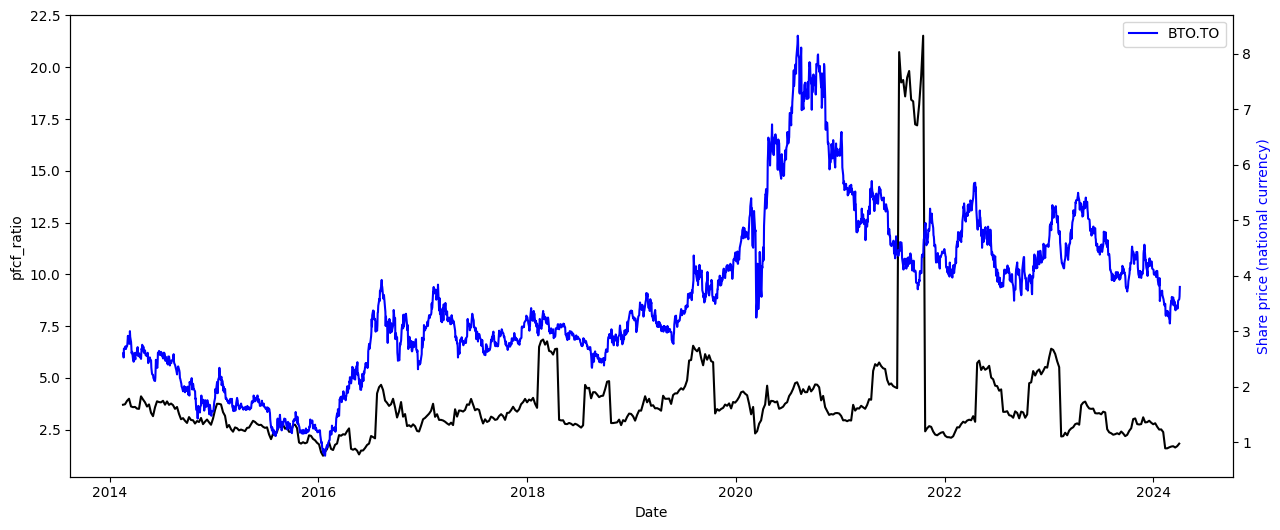

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

In [19]:
merged_nat_curr

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-02-17,2.690844,2013-12-31,144.815842,0.164412,2.630589,663.8,482.719475,0.727206,265.495711,...,5.368421,0.260870,0.188406,0.045022,0.062500,16.366483,1.022905,3.083540,3.795497,3.700248
1,2014-02-24,2.707767,2013-12-31,144.815842,0.164412,2.630589,663.8,482.719475,0.727206,265.495711,...,5.368421,0.260870,0.188406,0.045022,0.062500,16.469415,1.029338,3.102933,3.814890,3.723520
2,2014-03-03,2.826232,2013-12-31,144.815842,0.164412,2.630589,663.8,482.719475,0.727206,265.495711,...,5.368421,0.260870,0.188406,0.045022,0.062500,17.189953,1.074372,3.238687,3.950643,3.886424
3,2014-03-10,2.902388,2013-12-31,144.815842,0.164412,2.630589,663.8,482.719475,0.727206,265.495711,...,5.368421,0.260870,0.188406,0.045022,0.062500,17.653156,1.103322,3.325957,4.037914,3.991148
4,2014-03-17,2.631611,2013-12-31,144.815842,0.164412,2.630589,663.8,482.719475,0.727206,265.495711,...,5.368421,0.260870,0.188406,0.045022,0.062500,16.006214,1.000388,3.015664,3.727620,3.618796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,2024-03-04,3.506451,2023-12-31,697.148103,-0.514981,4.193570,1237.4,2581.626570,2.086331,418.016538,...,3.537572,0.402344,-0.228516,-0.096000,-0.122802,-6.808900,0.836149,1.555940,1.925569,1.680678
525,2024-03-11,3.540000,2023-12-31,697.148103,-0.514981,4.193570,1237.4,2581.626570,2.086331,418.016538,...,3.537572,0.402344,-0.228516,-0.096000,-0.122802,-6.874046,0.844149,1.570827,1.940456,1.696758
526,2024-03-18,3.410000,2023-12-31,697.148103,-0.514981,4.193570,1237.4,2581.626570,2.086331,418.016538,...,3.537572,0.402344,-0.228516,-0.096000,-0.122802,-6.621609,0.813150,1.513141,1.882770,1.634448
527,2024-03-25,3.550000,2023-12-31,697.148103,-0.514981,4.193570,1237.4,2581.626570,2.086331,418.016538,...,3.537572,0.402344,-0.228516,-0.096000,-0.122802,-6.893464,0.846534,1.575264,1.944893,1.701551


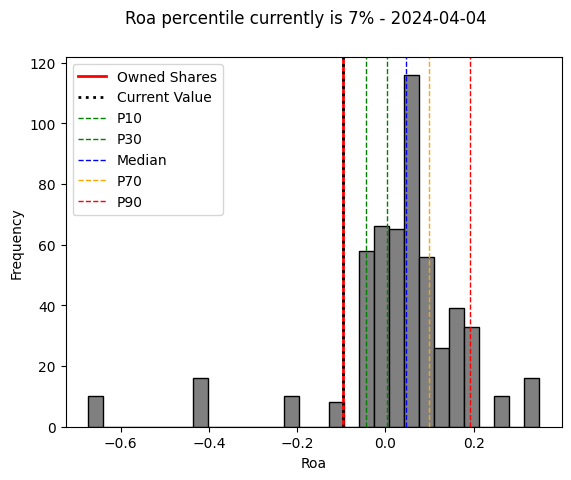

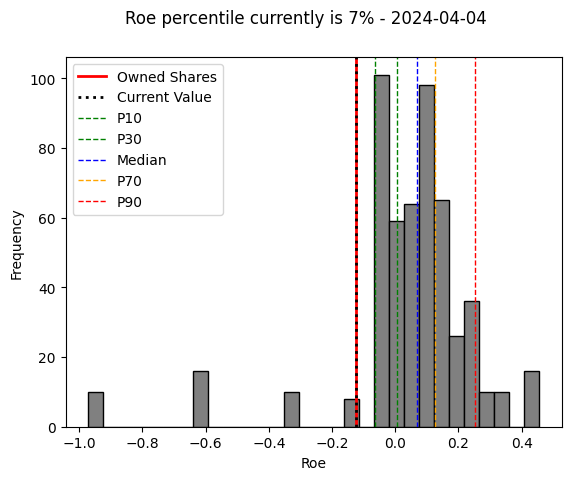

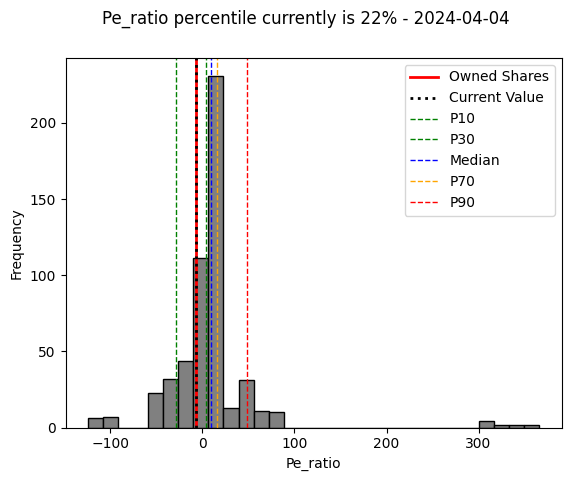

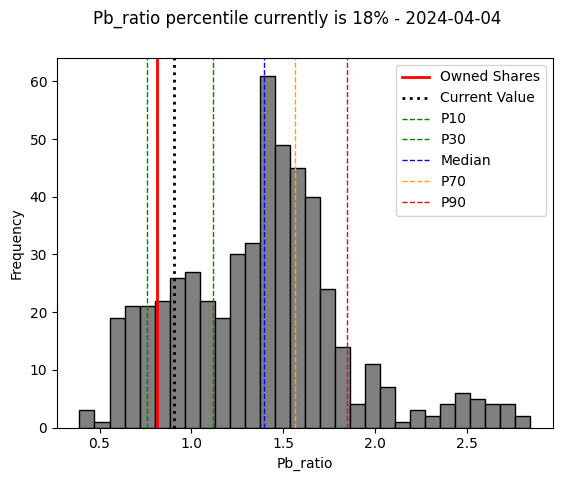

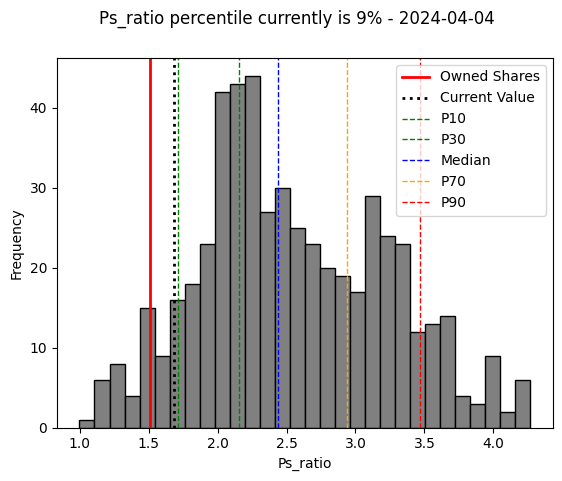

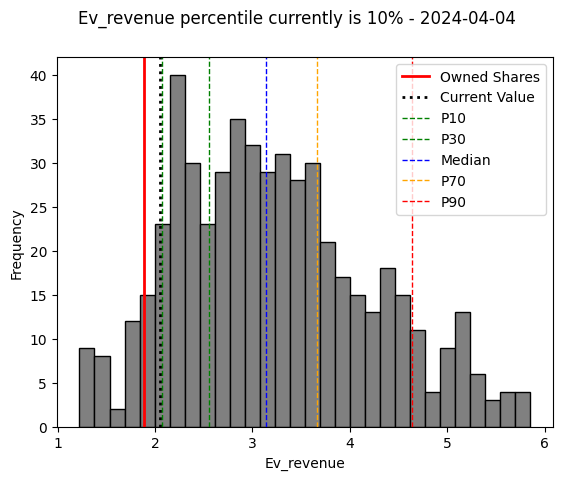

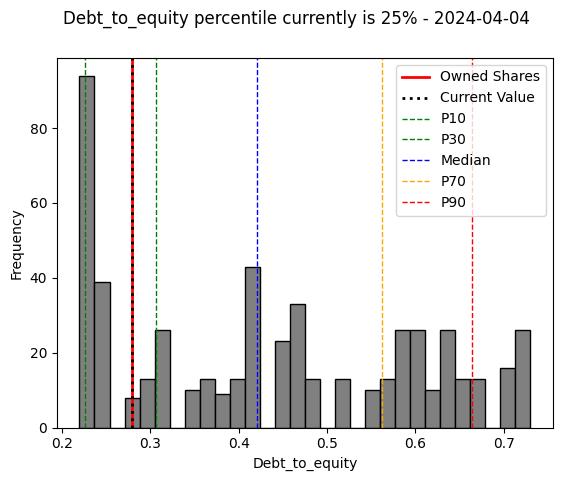

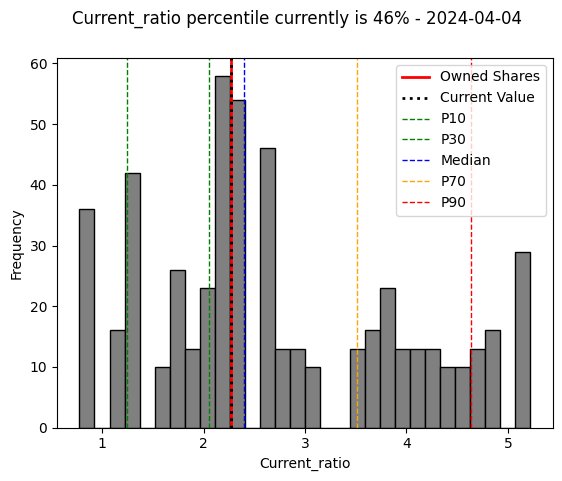

In [20]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [21]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.997783,0.067563,0.568401,-0.027291,-0.261757,-0.194134,0.036684
roe,0.997783,1.000000,0.073597,0.577240,-0.005988,-0.234220,-0.153623,0.001232
pe_ratio,0.067563,0.073597,1.000000,0.150675,0.052731,0.064868,0.188519,-0.177194
pb_ratio,0.568401,0.577240,0.150675,1.000000,0.514024,0.243252,0.166573,-0.175696
ps_ratio,-0.027291,-0.005988,0.052731,0.514024,1.000000,0.908679,0.479650,-0.285029
ev_revenue,-0.261757,-0.234220,0.064868,0.243252,0.908679,1.000000,0.719622,-0.497007
debt_to_equity,-0.194134,-0.153623,0.188519,0.166573,0.479650,0.719622,1.000000,-0.804074
current_ratio,0.036684,0.001232,-0.177194,-0.175696,-0.285029,-0.497007,-0.804074,1.000000


0 timestemos have been found!


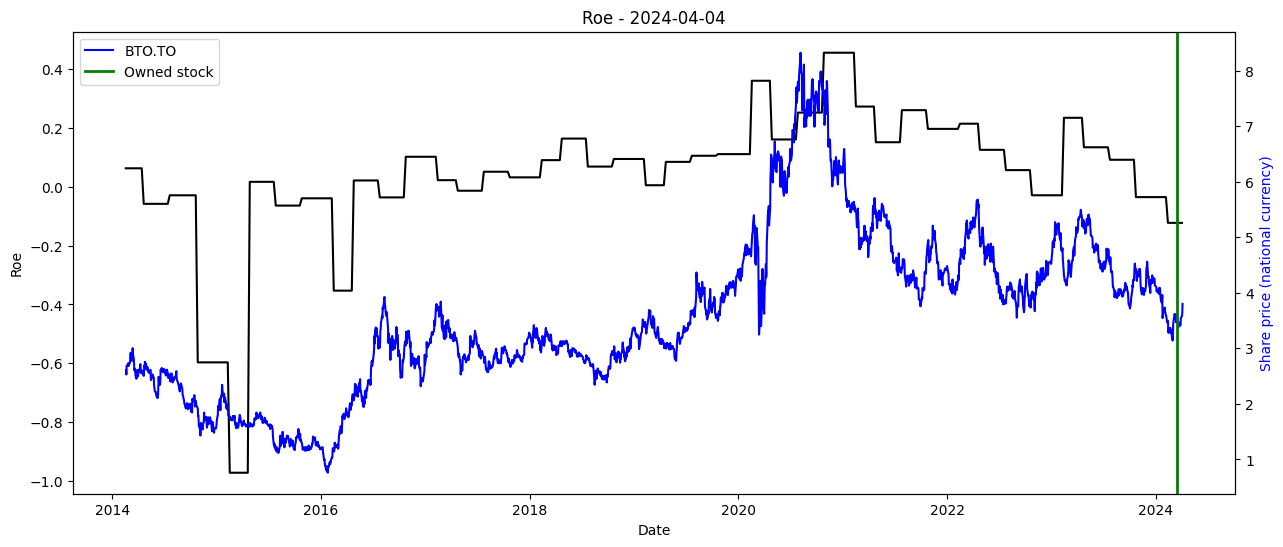

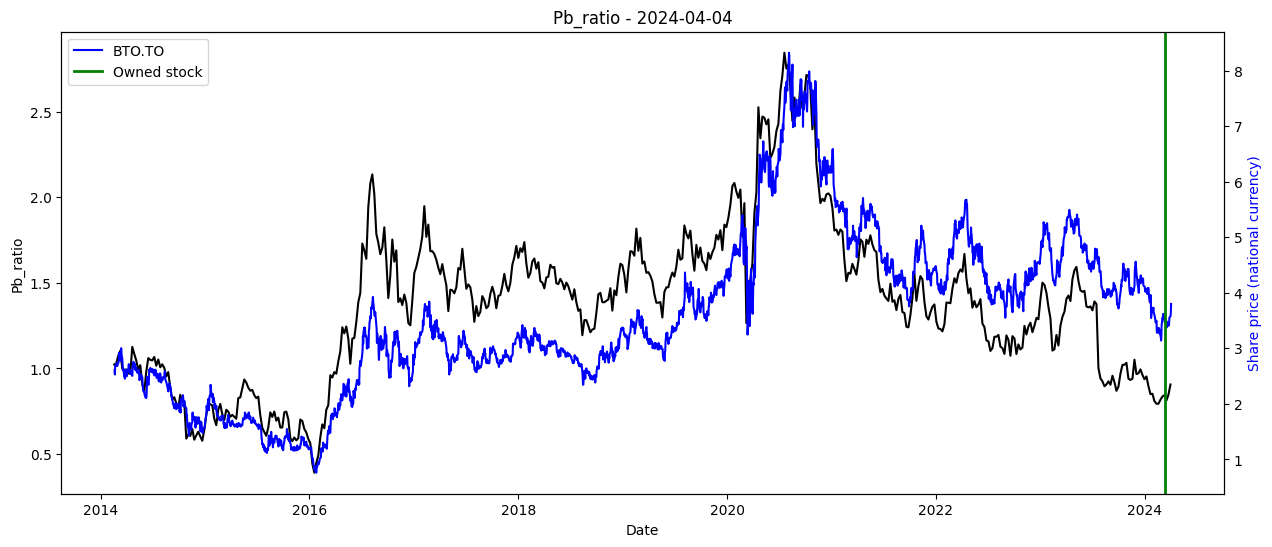

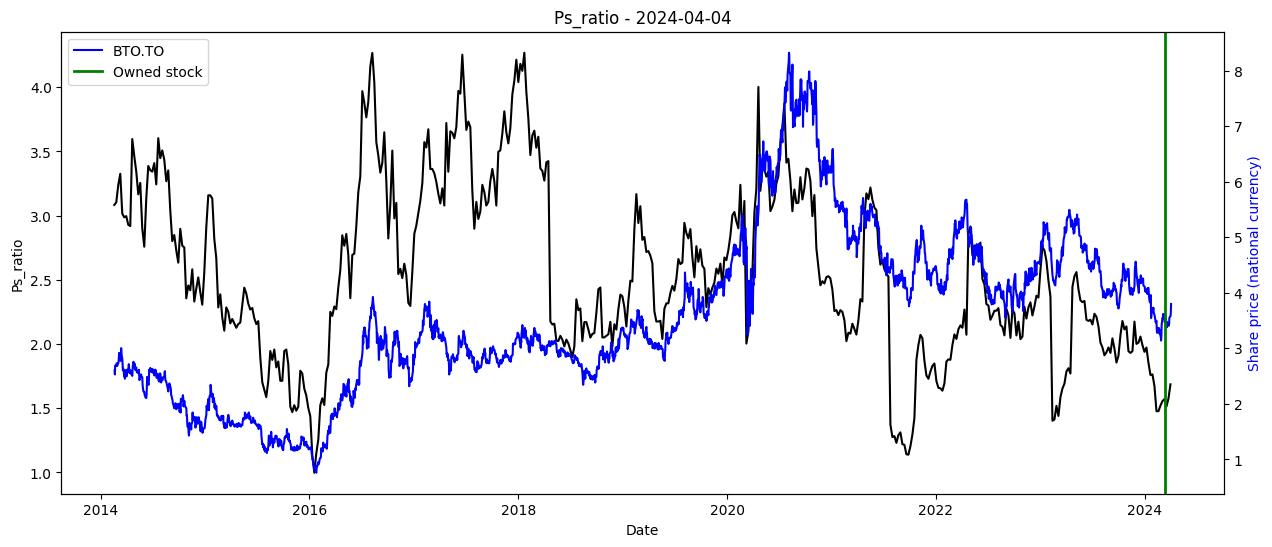

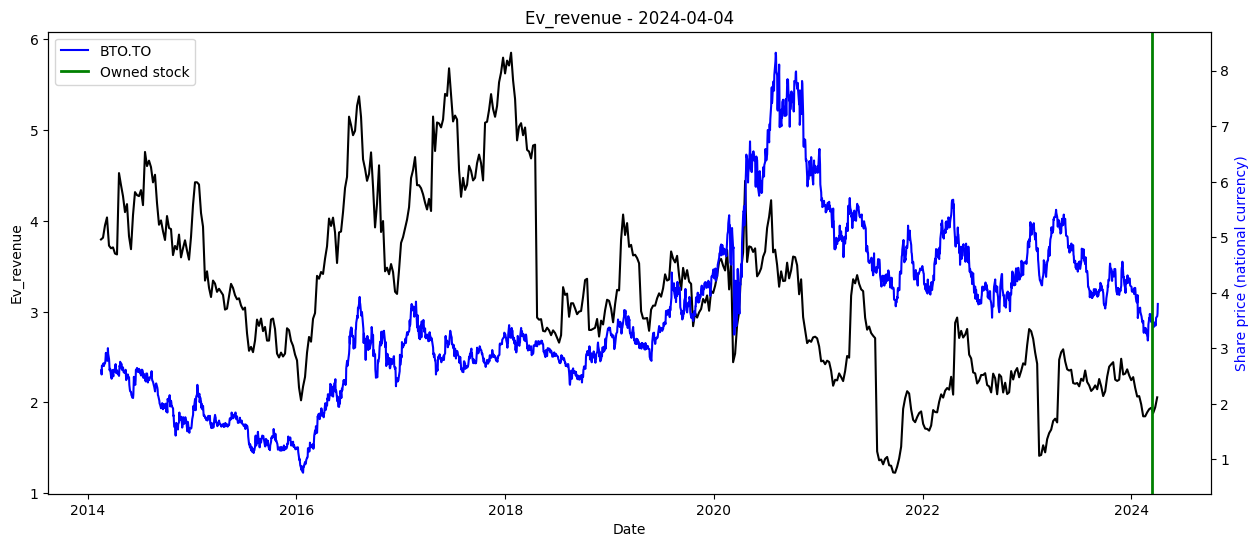

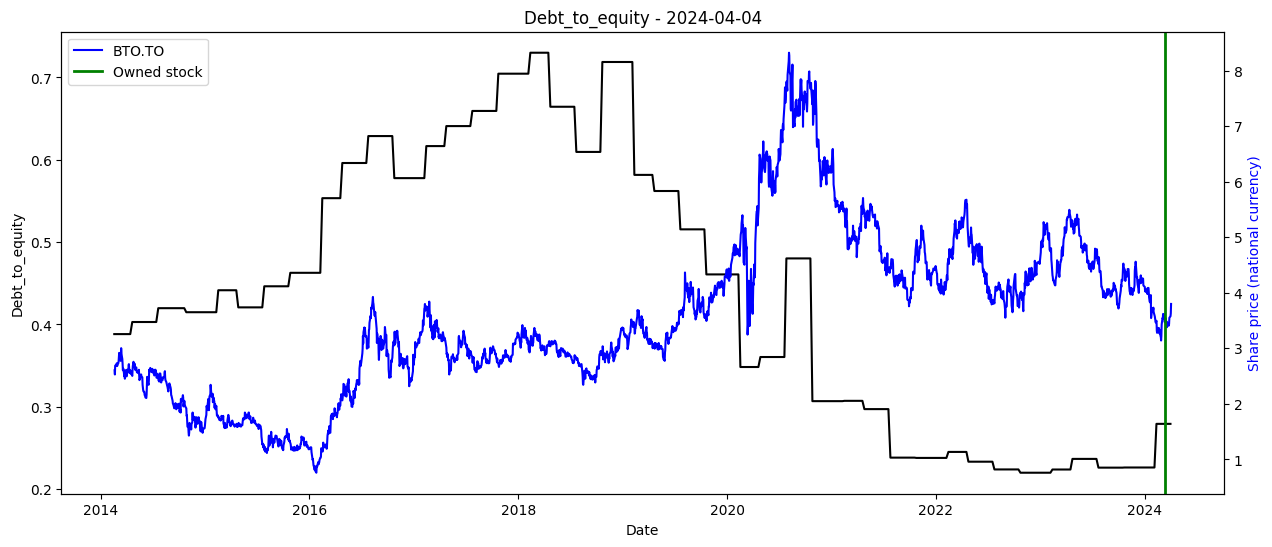

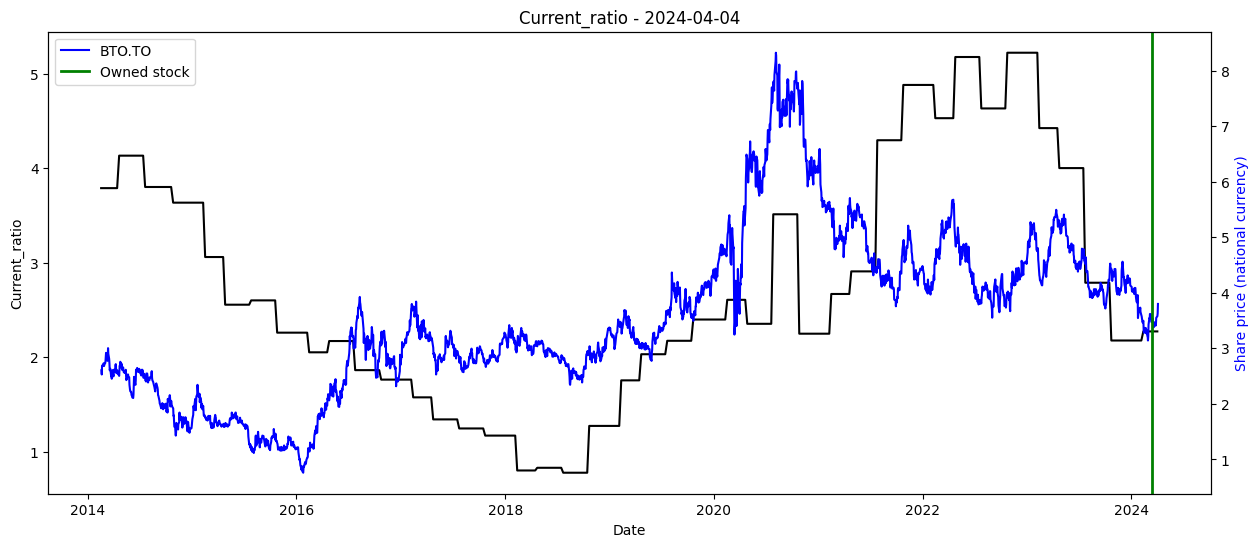

In [22]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )